In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import scipy.io as sio
train_dir = '../kaggle/working/train'
valid_dir = '../kaggle/working/valid'
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# from tqdm import tqdm_notebook, tnrange
# from itertools import chain
# from skimage.io import imread, imshow, concatenate_images
# from skimage.transform import resize
# from skimage.morphology import label
# from sklearn.model_selection import train_test_split

# import tensorflow as tf


import imgaug as ia
from imgaug import augmenters as iaa

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

['VA158C_sax_43.mat', 'VA175C_sax_53.mat', 'VA161C_sax_93.mat', 'VA172C_sax_113.mat', 'VA157_sax_103.mat', 'VA165C_sax_83.mat', 'VA163C_sax_123.mat', 'VA160C_sax_93.mat', 'VA155C_sax_133.mat', 'VA156C_sax_83.mat', 'VA170C_sax_113.mat', 'VA169C_sax_93.mat', 'VA162C_sax_93.mat', 'VA173C_sax_53.mat', 'VA166C_sax_113.mat', 'VA168C_sax_33.mat', 'VA174C_sax_93.mat', 'VA171C_sax_143.mat', 'VA164C_sax_63.mat']


Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:



#print(data) 
# lv_endo= sio.loadmat('VA155C_sax_93.mat',variable_names='lv_endo').get('lv_endo')
# rv_endo= sio.loadmat('VA155C_sax_93.mat',variable_names='rv_endo').get('rv_endo')
lv_ground=[]
rv_ground=[]
raw=[]
series_uid = []
patient_name = []
log_dir='../input'
raw_image={"Patient_name":"Raw_image"}
ground_truth={"Patient_name":"Labels"}
for file in os.listdir(log_dir):
    if file.endswith(".mat"):
        lv_endo= sio.loadmat(os.path.join(log_dir, file),variable_names='lv_endo').get('lv_endo')
        rv_endo = sio.loadmat(os.path.join(log_dir, file),variable_names='rv_endo').get('rv_endo')
        ground_truth.update({file.split("_")[0]:(lv_endo,rv_endo)})
        uid =  sio.loadmat(os.path.join(log_dir, file),variable_names='series_uid').get('series_uid')
        name =  sio.loadmat(os.path.join(log_dir, file),variable_names='patient_name').get('patient_name')
        lv_ground.append(lv_endo)
        rv_ground.append(rv_endo)

        #         raw_image.update({file.split("_")[0]:(sio.loadmat(os.path.join(log_dir, file),
        #                                                           variable_names='raw_image').get('raw_image'))})
        raw_image=sio.loadmat(os.path.join(log_dir, file),
                                                       variable_names='raw_image').get('raw_image')
        series_uid.append(uid)
        patient_name.append(name)

        raw.append(raw_image)

#del[raw_image["Patient_name"]]


# plt.imshow(data["raw_image"][0][1])
# plt.show()
# print(data["lv_endo"][0].shape)
# plt.show()

In [3]:

index=[]
left_ventricle =[]
right_ventricle = []
for img in range(len(raw)):
    for phase in range(raw[img].shape[0]):
        for slices in range(raw[img].shape[1]):
    #         print(lv_ground[0][i][j][0][0][0].shape)
            if lv_ground[img][phase][slices].size>0 and rv_ground[img][phase][slices].size>0:
                   left_ventricle.append(lv_ground[img][phase][slices][0][0][0])
                   right_ventricle.append(rv_ground[img][phase][slices][0][0][0])
            else : 
                index.append([img,phase,slices])
        

In [4]:
from skimage.transform import resize
train_data=raw[0][0][0]
data_train = []
diff_size=[]
less_size=[]
series_uid_list = []
for img in range(len(raw)):
    for phase in range(raw[img].shape[0]):
        for slices in range(raw[img].shape[1]):
            if [img,phase,slices] not in index :
                series_uid_list.append(series_uid[img])
                if raw[img][phase][slices].size>192*192:
#                 print(f"{img},{phase},{slices} and shape is{raw[img][phase][slices].shape}")
                    data_train.append(resize(raw[img][phase][slices], (192, 192), mode='constant', preserve_range=True))
                    diff_size.append([img,phase,slices])
                elif raw[img][phase][slices].size ==192*192:
                    data_train.append(raw[img][phase][slices])
                else:
                    less_size.append([img,phase,slices])
                
            
            
#                 if [img,phase,slices] not in index :
#                     plt.imshow(raw[img][phase][slices])
#                     plt.show()
#             if [img,phase,slices] not in index:
#                 train_data=np.concatenate((train_data,raw[img][phase][slices]))

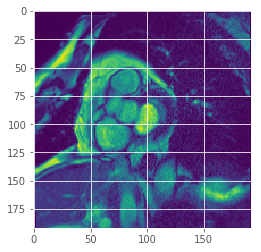

In [5]:
plt.imshow(data_train[10])

In [6]:
import cairo 
import cv2
def my_polygon_to_image(circ):
    image_size = (192,192)
    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, image_size[0], image_size[1])
    ctx = cairo.Context(surface)
    num_points = circ.shape[0]
    ctx.move_to(circ[0,0], circ[0,1])
    for i in range(num_points):
        ctx.line_to(circ[i,0], circ[i,1])
    ctx.close_path()
    ctx.set_source_rgb(1.0, 1.0, 1.0)
    ctx.fill()
    img = np.ndarray(shape=image_size,dtype=np.uint32,
    buffer=surface.get_data())
    return img/np.max(img)
def resize_images(img):
    image_size = (128,128)
    scaling_factor = img.shape[0] / float(128)
    # resize image
    images = cv2.resize(img, image_size, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
    return images
def greyscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
def my_image_to_polygon(img):
    contours = measure.find_contours(img, 0.5)
    # not sure why we need to add 0.5-pixel shift here
    contours = np.array(contours).reshape(-1,2) + 0.5
    return np.flip(contours,1)
# my_img = my_polygon_to_image(left_ventricle[0], (192,192))

# plt.imshow(my_img, cmap='gray');

In [7]:
lv_data=[*map(my_polygon_to_image, left_ventricle)]
# lv_data = [*map(resize_images,lv_data)]
rv_data = [*map(my_polygon_to_image, right_ventricle)]
# # rv_data = [*map(resize_images,rv_data)]
# data_train = [*map(greyscale,data_train)]

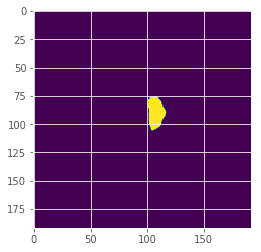

In [8]:
plt.imshow(lv_data[10])
# plt.imshow(data_train[10])
plt.show()

In [9]:
train_len = int(np.ceil(len(data_train)*0.65))
valid_len = int(np.ceil(len(data_train)*0.25))
test_len = len(data_train)-valid_len-train_len
training_set = data_train[:train_len]
valid_set = data_train[train_len : train_len + valid_len]
test_set = data_train[train_len+valid_len:]
train_labels_lv =  lv_data[:train_len]
valid_labels_lv = lv_data[train_len : train_len + valid_len]
test_labels_lv = lv_data[train_len+valid_len:]

In [10]:
train_series_uid = series_uid_list[:train_len]
valid_series_uid = series_uid_list[:valid_len]
test_series_uid = series_uid_list[:-test_len]


In [11]:
import os 
training_data_dict = {}
training_set = data_train
train_labels_lv = lv_data
training_data_dict["train_images"] = training_set
# training_data_dict["train_series_uid"] = train_series_uid
training_lv_label_dict = {}
training_lv_label_dict["train_labels_lv"] = train_labels_lv
os.makedirs(train_dir,exist_ok = True )
sio.savemat(os.path.join(train_dir,'training_input_images.mat'), training_data_dict)
sio.savemat(os.path.join(train_dir,'training_lv_label.mat'), training_lv_label_dict)
validation_data_dict = {}
validation_data_dict["validation_images"] =valid_set
# training_data_dict["train_series_uid"] = train_series_uid
validation_lv_label_dict = {}
validation_lv_label_dict["validation_labels_lv"] = valid_labels_lv
valid_dir = '../kaggle/working/valid'
os.makedirs(valid_dir,exist_ok = True )

sio.savemat(os.path.join(valid_dir,'validation_input_images.mat'), validation_data_dict)
sio.savemat(os.path.join(valid_dir,'validation_lv_label.mat'), validation_lv_label_dict)

In [12]:

validation_input_images = sio.loadmat(os.path.join(valid_dir,'validation_input_images.mat'),variable_names='validation_images').get('validation_images')
validation_lv_labels = sio.loadmat(os.path.join(valid_dir,'validation_lv_label.mat'),variable_names="validation_labels_lv").get('validation_labels_lv')
# validation_input_images = cv2.resize(validation_input_images,(128,128))
# validation_lv_labels = cv2.resize(validation_lv_labels,(128,128))
validation_lv_labels = validation_lv_labels[:,:,:,np.newaxis]
validation_input_images = validation_input_images[:,:,:,np.newaxis]


#    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [14]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=True)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])

    return model

In [15]:
def create_generator(images,masks,batch_size):
    data_gen_args = dict(
                         rotation_range=40,
                         width_shift_range=0.3,
                         height_shift_range=0.3,
                         zoom_range=0.2)
    seed = 1
    image_datagen =  ImageDataGenerator(**data_gen_args).flow(images, images,batch_size,seed=seed)
    mask_datagen = ImageDataGenerator(**data_gen_args).flow(masks,masks,batch_size,seed=seed)

#     # Provide the same seed and keyword arguments to the fit and flow methods

#     # combine generators into one which yields image and masks
#     train_generator = zip(image_datagen, mask_datagen)
#     return train_generator
    while True:
        x_batch, _ = image_datagen.next()
        y_batch, _ = mask_datagen.next()
        yield x_batch, y_batch


In [16]:
train_lv_label = sio.loadmat(os.path.join(train_dir,'training_lv_label.mat'),variable_names='train_labels_lv').get('train_labels_lv')
train_input_images = sio.loadmat(os.path.join(train_dir,'training_input_images.mat'),variable_names='train_images').get('train_images') 


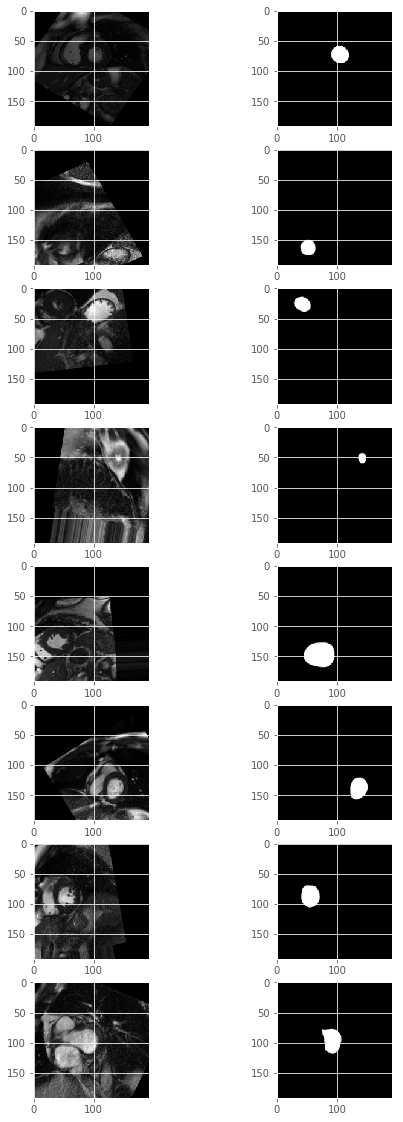

In [17]:
train_lv_label = train_lv_label[:,:,:,np.newaxis]
train_input_images = train_input_images[:,:,:,np.newaxis]
image_batch, mask_batch = next(create_generator(train_input_images, train_lv_label, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0],cmap = 'gray')
    ax[i,1].imshow(mask_batch[i,:,:,0],cmap = 'gray' )
plt.show()

In [18]:
import keras.backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


In [19]:
input_img = Input((192, 192, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 192, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 192, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 192, 192, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [21]:
# callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('../model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]
weight_saver = ModelCheckpoint('left_ventricle.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)


In [22]:
train_input_images[0].shape

(192, 192, 1)

In [23]:
hist = model.fit_generator(create_generator(train_input_images, train_lv_label, 8),
                           steps_per_epoch = 200,
                           validation_data = (validation_input_images, validation_lv_labels),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer])

Epoch 1/10
 - 28s - loss: 0.1979 - dice_coef: 0.2177 - val_loss: 0.1155 - val_dice_coef: 0.3333
Epoch 2/10
 - 20s - loss: 0.0640 - dice_coef: 0.4674 - val_loss: 0.0640 - val_dice_coef: 0.4185
Epoch 3/10
 - 20s - loss: 0.0413 - dice_coef: 0.5854 - val_loss: 0.0312 - val_dice_coef: 0.6484
Epoch 4/10
 - 20s - loss: 0.0289 - dice_coef: 0.6900 - val_loss: 0.0232 - val_dice_coef: 0.6995
Epoch 5/10
 - 20s - loss: 0.0237 - dice_coef: 0.7424 - val_loss: 0.0202 - val_dice_coef: 0.7367
Epoch 6/10
 - 20s - loss: 0.0203 - dice_coef: 0.7700 - val_loss: 0.0237 - val_dice_coef: 0.7508
Epoch 7/10
 - 20s - loss: 0.0172 - dice_coef: 0.8023 - val_loss: 0.0195 - val_dice_coef: 0.7745
Epoch 8/10
 - 19s - loss: 0.0166 - dice_coef: 0.8115 - val_loss: 0.0172 - val_dice_coef: 0.7994
Epoch 9/10
 - 19s - loss: 0.0158 - dice_coef: 0.8227 - val_loss: 0.0149 - val_dice_coef: 0.8083
Epoch 10/10
 - 19s - loss: 0.0144 - dice_coef: 0.8343 - val_loss: 0.0142 - val_dice_coef: 0.8260


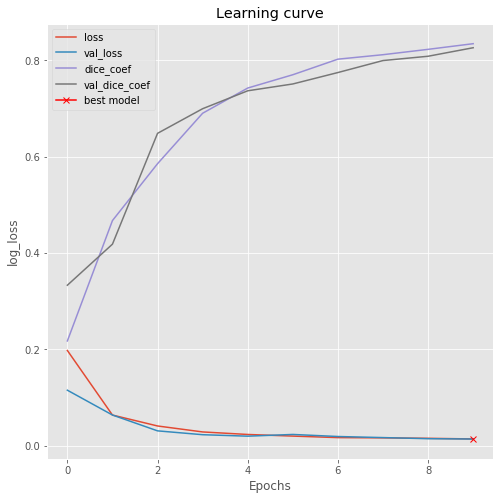

In [24]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["dice_coef"],label ="dice_coef")
plt.plot(hist.history["val_dice_coef"],label ="val_dice_coef")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [25]:
test_data_dict = {}
test_data_dict["test_images"] = test_set
test_lv_label_dict = {}
test_lv_label_dict["test_labels_lv"] = test_labels_lv
test_dir = '../kaggle/working/test'
os.makedirs(test_dir,exist_ok = True )

sio.savemat(os.path.join(test_dir,'test_input_images.mat'), test_data_dict)
sio.savemat(os.path.join(test_dir,'test_lv_label.mat'), test_lv_label_dict)

test_input_images = sio.loadmat(os.path.join(test_dir,'test_input_images.mat'),variable_names='test_images').get('test_images')
test_lv_labels = sio.loadmat(os.path.join(test_dir,'test_lv_label.mat'),variable_names="test_labels_lv").get('test_labels_lv')
# validation_input_images = cv2.resize(validation_input_images,(128,128))
# validation_lv_labels = cv2.resize(validation_lv_labels,(128,128))
test_lv_labels = test_lv_labels[:,:,:,np.newaxis]
test_input_images = test_input_images[:,:,:,np.newaxis]

In [26]:
y_hat = model.predict(test_input_images)


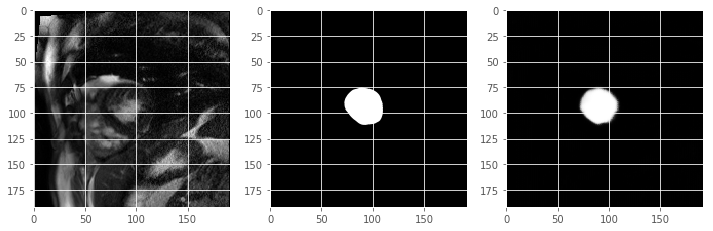

In [27]:
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(test_set[100], cmap='gray')
ax[1].imshow(test_labels_lv[100],cmap='gray')
ax[2].imshow(y_hat[100,:,:,0],cmap='gray')

In [28]:
dice_test=dice_coef(np.array(test_labels_lv,np.float32) , np.array(y_hat,np.float32))

In [29]:
import tensorflow as tf
sess = tf.Session()
sess.run(dice_test)

0.84867245